In [1]:
%matplotlib notebook
from matplotlib import pyplot as plot
from matplotlib import cm

In [2]:
import numpy
from collections import OrderedDict

In [3]:
fname = './routes.dat'

In [4]:
# Airport ID	Unique OpenFlights identifier for this airport.
# Name	Name of airport. May or may not contain the City name.
# City	Main city served by airport. May be spelled differently from Name.
# Country	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
# IATA	3-letter IATA code. Null if not assigned/unknown.
# ICAO	4-letter ICAO code.
# Null if not assigned.
# Latitude	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
# Longitude	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
# Altitude	In feet.
# Timezone	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
# DST	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
# Tz database time zone	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
# Type	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
# Source	Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.

In [5]:
aid2city = OrderedDict()

idx = 0
with open('./airports-extended.dat', 'r') as f:
    for line in f:
        ll = line.strip().split(',')
        aid2city[ll[0]] = ll[2]

In [6]:
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

In [7]:
airport2aid = OrderedDict()
airport2idx = OrderedDict()

idx = 0
with open('./routes.dat', 'r') as f:
    for line in f:
        ll = line.strip().split(',')
        airport2aid[ll[2]] = ll[3]
        if ll[2] not in airport2idx:
            airport2idx[ll[2]] = idx
            idx += 1
        airport2aid[ll[4]] = ll[5]
        if ll[4] not in airport2idx:
            airport2idx[ll[4]] = idx
            idx += 1
            
idx2airport = OrderedDict([(vv,kk) for kk, vv in airport2idx.items()])

In [8]:
n_airports = len(airport2idx.keys())

In [9]:
connections = numpy.zeros((n_airports, n_airports))

with open(fname, 'r') as f:
    for line in f:
        ll = line.strip().split(',')
        if ll[7] != '0':
            continue
        sidx = airport2idx[ll[2]]
        tidx = airport2idx[ll[4]]
        connections[sidx, tidx] += 1
        connections[tidx, sidx] += 1

In [18]:
weights = 1./connections

/Users/kyunghyuncho/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':


In [22]:
weights[numpy.isnan(weights)] = 10.
weights[numpy.isinf(weights)] = 10.

In [23]:
#weights[numpy.where(weights==numpy.nan)] = 10.
print weights

[[ 10.    0.5  10.  ...,  10.   10.   10. ]
 [  0.5  10.    0.5 ...,  10.   10.   10. ]
 [ 10.    0.5  10.  ...,  10.   10.   10. ]
 ..., 
 [ 10.   10.   10.  ...,  10.    0.5  10. ]
 [ 10.   10.   10.  ...,   0.5  10.   10. ]
 [ 10.   10.   10.  ...,  10.   10.   10. ]]


In [24]:
per_airport = connections.sum(1)/2.
sorted_idx = numpy.argsort(per_airport)[::-1]

In [27]:
# take the top-100 most-connected airports
n_top = 100
weights_major = weights[sorted_idx[:n_top],:]
weights_major = weights_major[:,sorted_idx[:n_top]]

In [28]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed', n_jobs=1, verbose=1)

In [29]:
fitted = mds.fit_transform(weights_major)

breaking at iteration 108 with stress 54534.4278844
breaking at iteration 135 with stress 68957.871151
breaking at iteration 70 with stress 57596.7840139
breaking at iteration 86 with stress 60965.150313


<IPython.core.display.Javascript object>


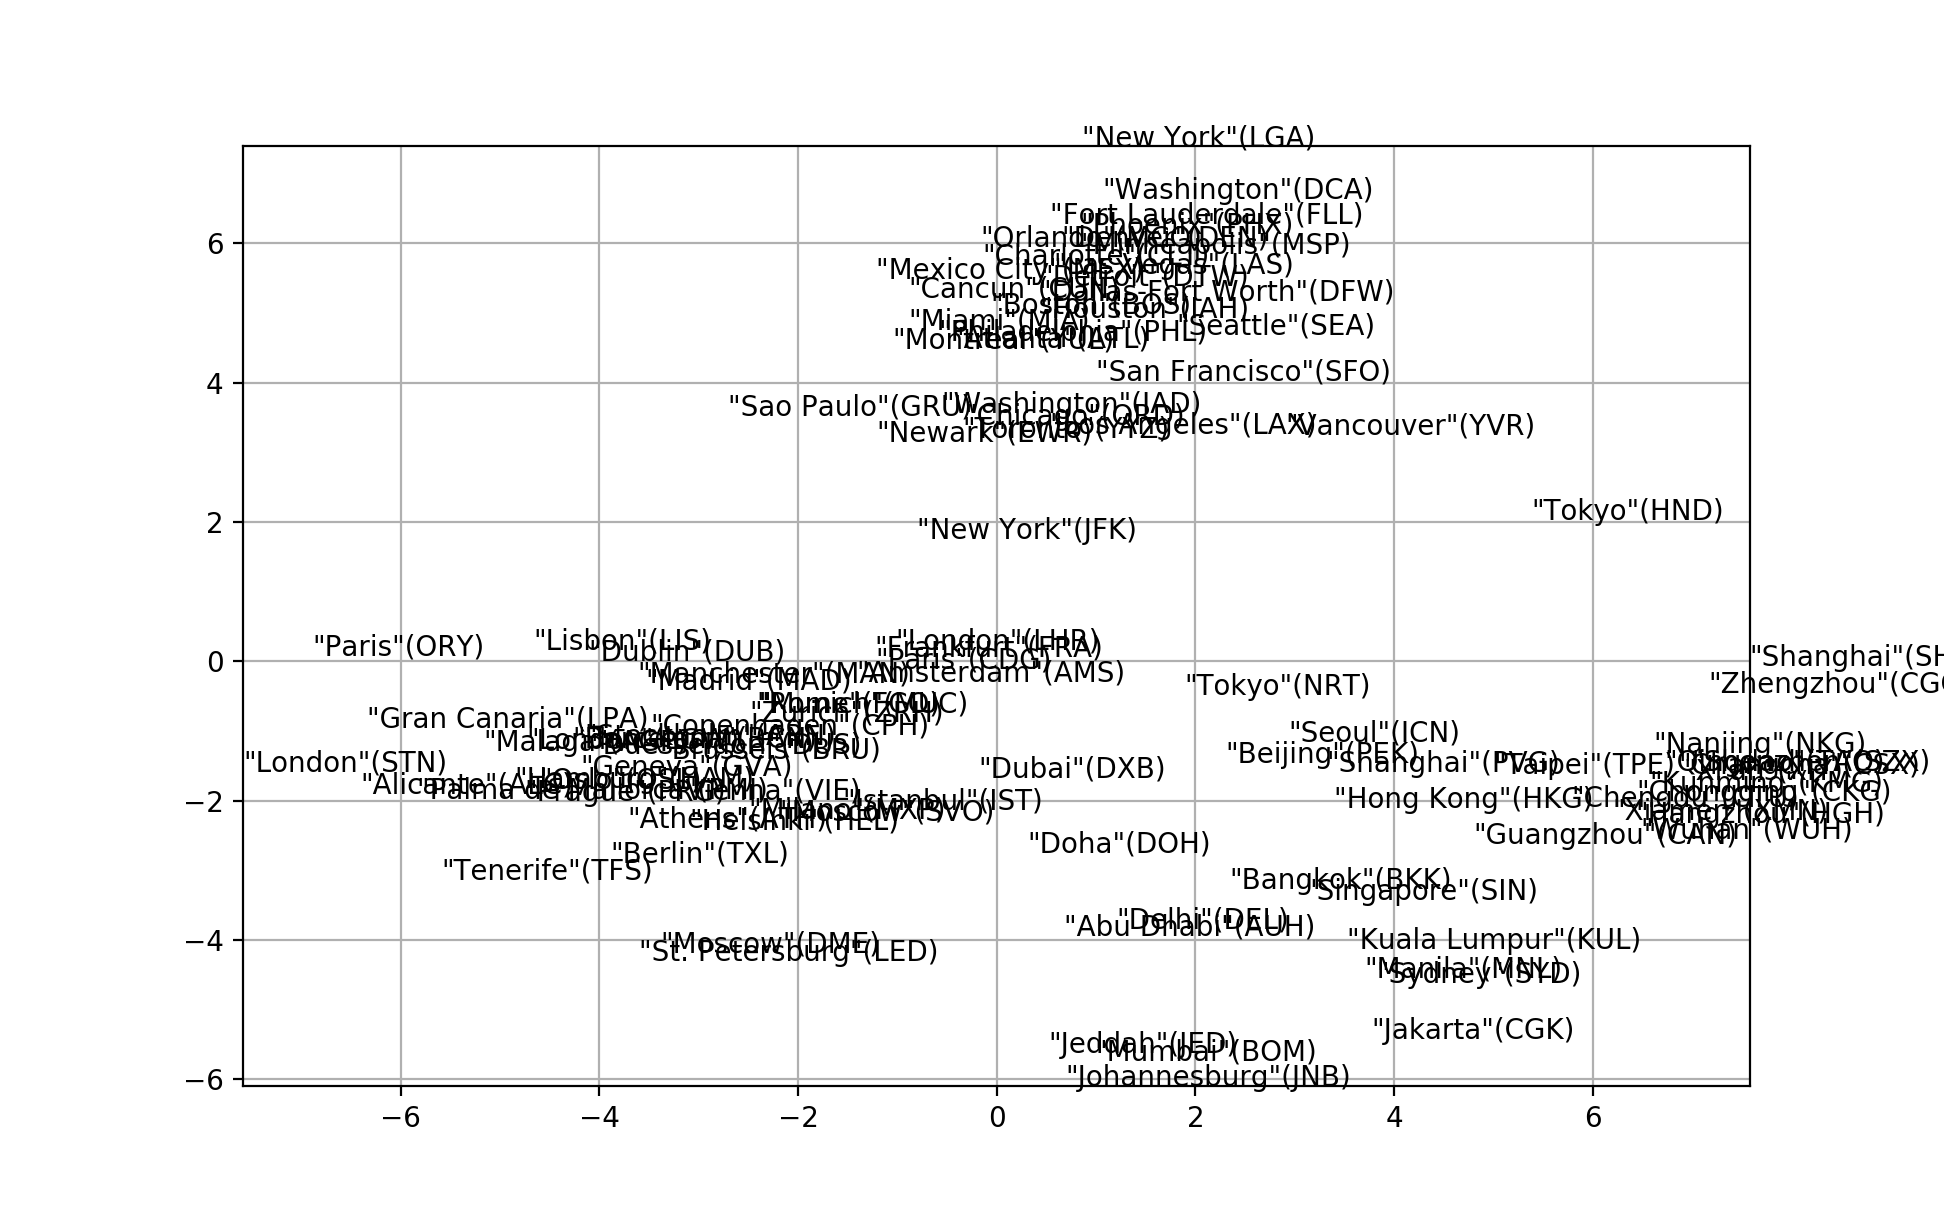

In [30]:
plot.figure()

for ii in xrange(fitted.shape[0]): #sorted_idx[:100]:
    airport = idx2airport[sorted_idx[ii]]
    aid = airport2aid[airport]
    if aid not in aid2city:
        continue
    city = aid2city[aid]
    plot.annotate('{}({})'.format(city.decode('utf8'),airport.decode('utf8')), (fitted[ii,0], fitted[ii,1]))
    
plot.xlim([fitted.min(0)[0], fitted.max(0)[0]])
plot.ylim([fitted.min(0)[1], fitted.max(0)[1]])
plot.grid('on')

plot.show()